In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

In [2]:
transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

In [3]:
dataset = datasets.MNIST(root="dataset/",transform=transforms,download=True)

In [4]:
def get_number(num):
    fig, axes = plt.subplots(5,5,figsize=(20,20),subplot_kw=dict(xticks=[], yticks=[]))
    for i, ax in enumerate(axes.flat):
        ax.imshow(dataset.train_data[dataset.targets==num][i], cmap='bone')
        ax.set_title(num)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


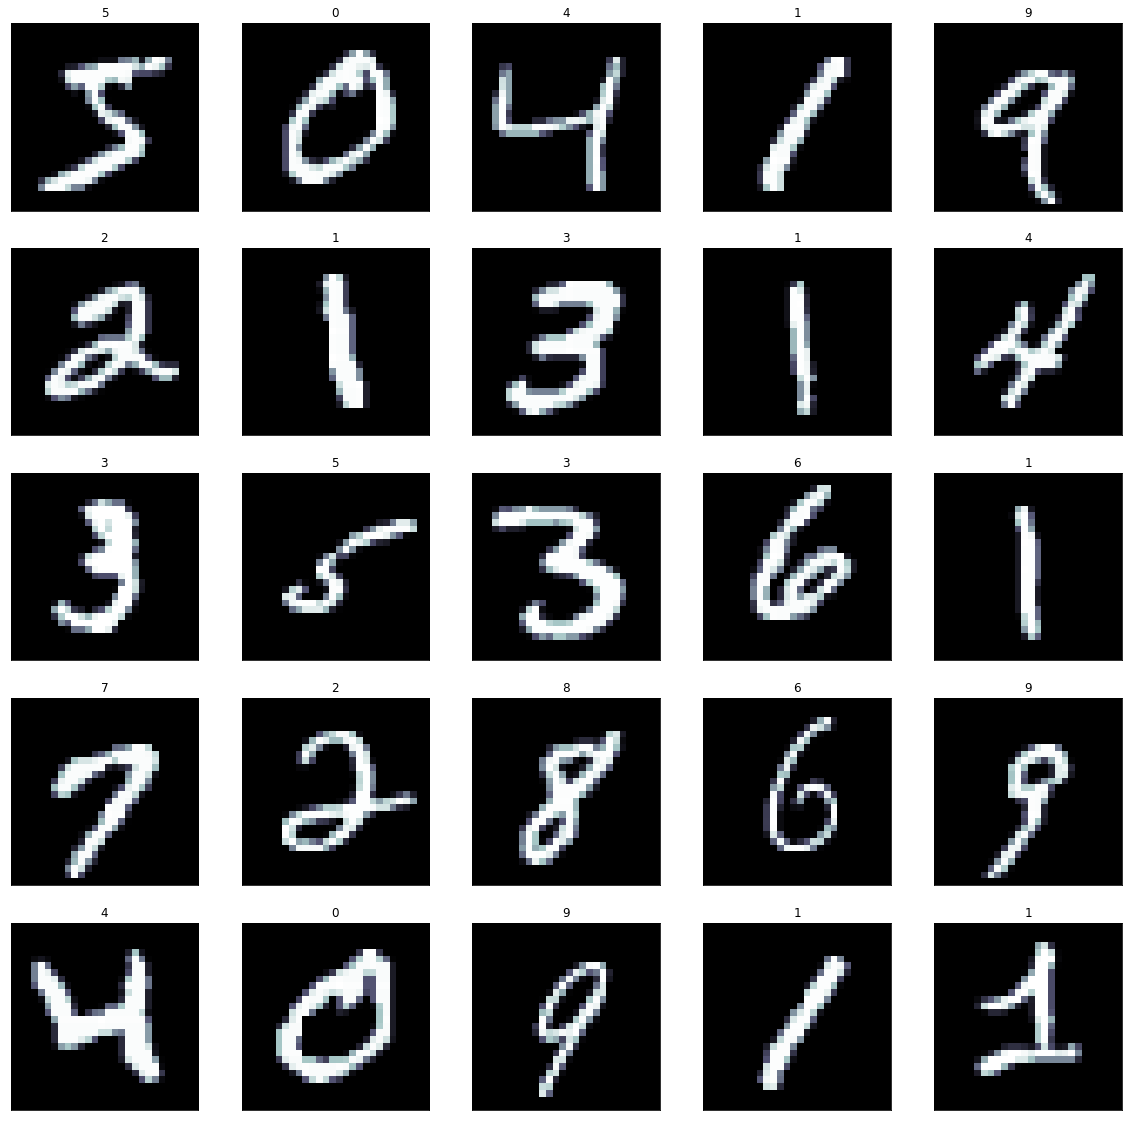

In [5]:
fig, axes = plt.subplots(5,5,figsize=(20,20),subplot_kw=dict(xticks=[], yticks=[]))
for i, ax in enumerate(axes.flat):
    ax.imshow(dataset.train_data[i], cmap='bone')
    ax.set_title(dataset.targets.tolist()[i])

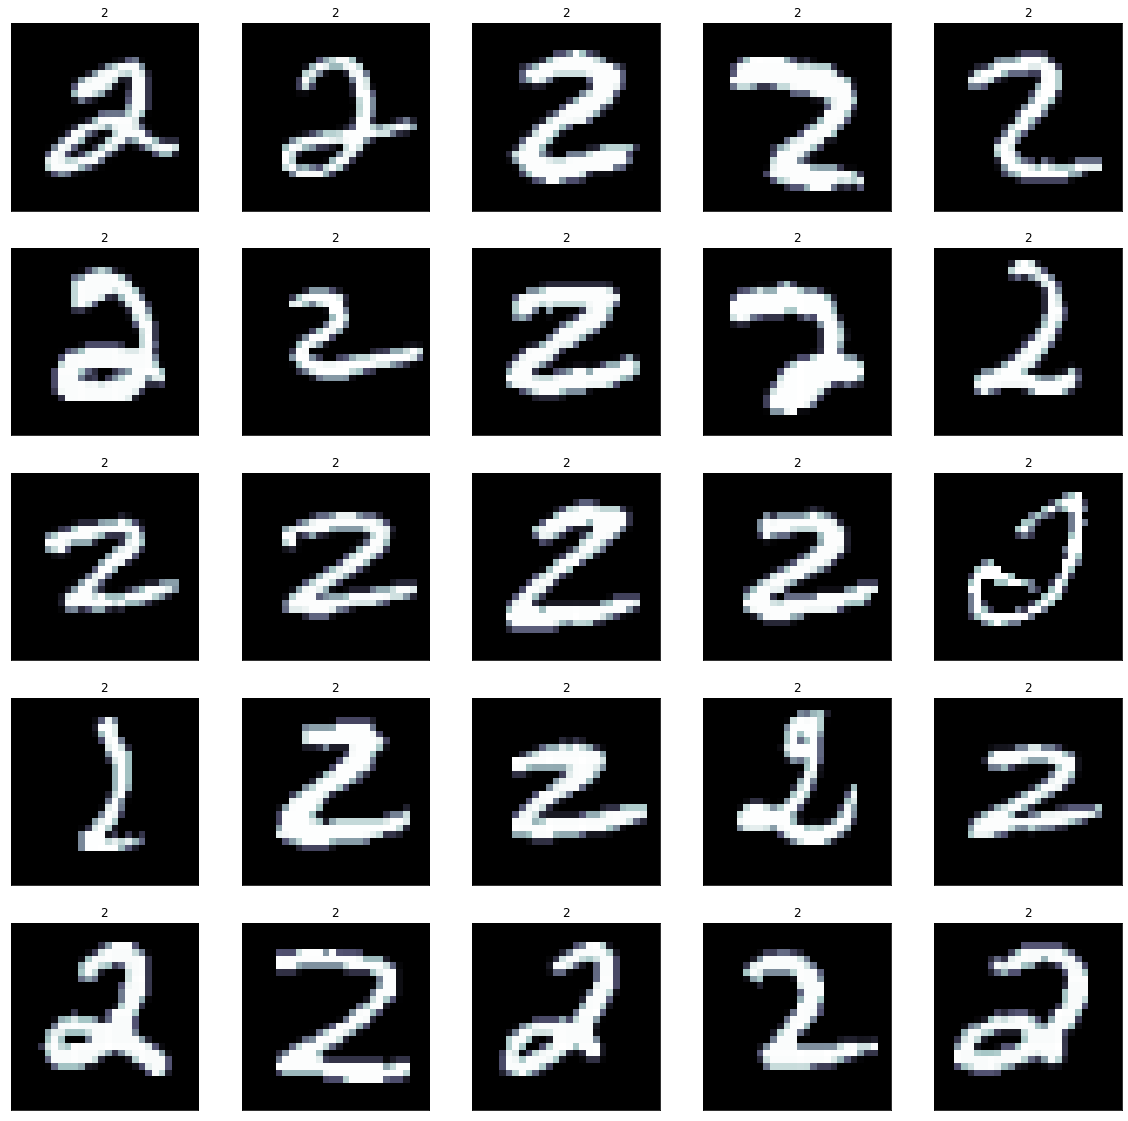

In [6]:
get_number(2)

In [7]:
class discriminator(nn.Module):
    def __init__(self, in_feature):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_feature, 128), 
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.disc(x)

In [8]:
class generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256), 
            nn.LeakyReLU(0.01), 
            nn.Linear(256, img_dim),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.gen(x)

In [17]:
#hyperparameter
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 3e-4
z_dim = 64
image_dim = 28 * 28 * 1  # 784
batch_size = 32
num_epochs = 50
step=0

In [10]:
disc = discriminator(image_dim).to(device)
gen = generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

In [19]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")

In [35]:
for epoch in range(num_epochs):
    for batch_idx, (real, label) in enumerate(loader):
        real_data = real.view(-1, 784).to(device)
        batch_size = real.shape[0]
        
        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake_data = gen(noise)
        
        disc_real = disc(real_data).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake_data).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real+lossD_fake)/2
        
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()
        
        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from saturating gradients
        output = disc(fake_data).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        
        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )
            
            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                step += 1

Epoch [0/50] Batch 0/1875                       Loss D: 0.5862, loss G: 1.0288
Epoch [1/50] Batch 0/1875                       Loss D: 0.5524, loss G: 1.1543
Epoch [2/50] Batch 0/1875                       Loss D: 0.5339, loss G: 1.1783
Epoch [3/50] Batch 0/1875                       Loss D: 0.5130, loss G: 1.3524
Epoch [4/50] Batch 0/1875                       Loss D: 0.6445, loss G: 0.9793
Epoch [5/50] Batch 0/1875                       Loss D: 0.6487, loss G: 1.0801
Epoch [6/50] Batch 0/1875                       Loss D: 0.6598, loss G: 0.8110
Epoch [7/50] Batch 0/1875                       Loss D: 0.6252, loss G: 1.0345
Epoch [8/50] Batch 0/1875                       Loss D: 0.5413, loss G: 1.0064
Epoch [9/50] Batch 0/1875                       Loss D: 0.4629, loss G: 1.1508
Epoch [10/50] Batch 0/1875                       Loss D: 0.6025, loss G: 0.8622
Epoch [11/50] Batch 0/1875                       Loss D: 0.5986, loss G: 1.1054
Epoch [12/50] Batch 0/1875                       L

In [36]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 18481), started 0:15:35 ago. (Use '!kill 18481' to kill it.)